In [4]:
# ativos_label = ["ABEV3.SA", "BTOW3.SA", "B3SA3.SA","BBSE3.SA", "BRML3.SA", "BBDC3.SA", "BBDC4.SA","BRAP4.SA","BBAS3.SA","BRKM5.SA","BRFS3.SA", "CCRO3.SA","CMIG4.SA","HGTX3.SA","CIEL3.SA","COGN3.SA","CSAN3.SA","CVCB3.SA","CYRE3.SA","ECOR3.SA","ELET3.SA","ELET6.SA","EMBR3.SA","ENBR3.SA","EGIE3.SA","EQTL3.SA","FLRY3.SA","GGBR4.SA","GOAU4.SA","GOLL4.SA","HYPE3.SA","IGTA3.SA","ITSA4.SA","ITUB4.SA","JBSS3.SA","KLBN11.SA","RENT3.SA","LAME4.SA","LREN3.SA","MGLU3.SA","MRFG3.SA","MRVE3.SA","MULT3.SA","PET

In [5]:
# install yfinance
!pip install tensorflow
!pip install yfinance --upgrade --no-cache-dir
!pip install jupyter notebook
!pip install pandas
!pip install yahoofinancials
!pip install pandas_datareader
!pip install matplotlib
!pip install sklearn

# TensorFlow e tf.keras
import tensorflow as tf
from tensorflow import keras

# finance data
# from yahoofinancials import YahooFinancials
import yfinance as yf
import pandas_datareader as web

# data science
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# IA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

# Librariesauxiliares
from datetime import datetime
import math
from collections import deque
from statistics import mean

print(tf.__version__)

updateAssets = True

██████| 1.0 MB 16.8 MB/s 
     |████████████████████████████████| 65 kB 568 kB/s 
     |████████████████████████████████| 4.0 MB 7.0 MB/s 
     |████████████████████████████████| 288 kB 24.0 MB/s 
     |████████████████████████████████| 97 kB 1.5 MB/s 
     |████████████████████████████████| 4.9 MB 22.2 MB/s 
     |████████████████████████████████| 781 kB 8.4 MB/s 
  Using cached google_auth-1.30.0-py2.py3-none-any.whl (146 kB)
  Using cached pyasn1_modules-0.2.8-py2.py3-none-any.whl (155 kB)
  Using cached requests_oauthlib-1.3.0-py2.py3-none-any.whl (23 kB)
  Using cached pyasn1-0.4.8-py2.py3-none-any.whl (77 kB)
  Using cached oauthlib-3.1.0-py2.py3-none-any.whl (147 kB)
  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=5679 sha256=cd9e27532c676bd20349089145e344e9a14d6354da65957e4cfea13d8bbc264c
  Stored in directory: /home/lucas/.cache/pip/wheels/93/2a/eb/e58dbcbc963549ee4f065ff80a59f274cc7210b6eab962acdc
  Created wheel for wrapt: filename=wrapt-1.12.1-

In [32]:
# periodo analisado dos ativos
startDate = '1990-01-01' #'2013-01-01' #'1990-01-01'
endDate = '2022-01-01' #'2016-01-01' #'2022-01-01'

In [33]:
# tratamento dos dados
def addVariablesToDatasetBasedOnAssetName(dataset, assetName, createType=0):
  dataset = sanitizeRegisters(dataset)
  dataset = addClosureVariationsTo(dataset)
  
  if createType == 0:
    dataset = addFundamentalParametersTo(dataset)
    dataset = cutDatasetBasedOnOperatingIncomeValuesWithMargin(dataset, 52 * 7)
    dataset = addTechnicalParametersTo(dataset)
    dataset = addEconomicalParametersTo(dataset)
    dataset = cutDatasetBasedOnOperatingIncomeValuesWithMargin(dataset)
    dataset = dataset.fillna(0)

    nonStationarySeries = [
        'Asset Turnover', 'Operating Income'
    ]
    dataset = calculateDifferencesOfFieldsInDataset(nonStationarySeries, dataset)

  return dataset


def sanitizeRegisters(asset):
  for assetColumn in asset.columns:
    if (assetColumn) == 'Date':
      asset[assetColumn] = asset[assetColumn].apply(lambda x: convertToDate(x))
    else:
      asset[assetColumn] = asset[assetColumn].apply(lambda x: convertToFloat(x))
  return asset


def addClosureVariationsTo(asset):
  assetClosureVariations = [0]  
  for i in range(1, len(asset)):
    assetClosureVariations.append(assetClosureVariation(asset.iloc[i]['Close'], asset.iloc[i - 1]['Close']))
  asset['Var'] = assetClosureVariations
  return asset


def addFundamentalParametersTo(dataset):
  variables = yf.Ticker(assetName)
  dataset = addDividendsToDataset(variables, dataset)
  dataset = addEarningsToDataset(variables, dataset)
  dataset = addOperatingIncomeToDataset(variables, dataset)
  dataset = addRatiosToDataset(variables, dataset)
  dataset = addEPSToDataset(variables, dataset)
  dataset = addGrossProfitMarginToDataset(variables, dataset)
  dataset = addOperatingProfitMarginToDataset(variables, dataset)
  dataset = addROAToDataset(variables, dataset)
  dataset = addRNOAToDataset(variables, dataset)
  dataset = addROEToDataset(variables, dataset)
  dataset = addInventoryTurnoverToDataset(variables, dataset)
  dataset = addReceivableTurnoverToDataset(variables, dataset)
  dataset = addAssetTurnoverToDataset(variables, dataset)
  dataset = addOperatingCashflowToDataset(variables, dataset)
  dataset = addFreeCashflowToDataset(variables, dataset)
  dataset = addCashflowToDebtRatioToDataset(variables, dataset)
  dataset = addCashflowExpenditureRatioToDataset(variables, dataset)
  dataset = addCurrentRatioToDataset(variables, dataset)
  dataset = addQuickRatioToDataset(variables, dataset)
  dataset = addInterestCoverageRatioToDataset(variables, dataset)
  dataset = addDebtToEquityRatioToDataset(variables, dataset)
  dataset = addDebtToCapitalRatioToDataset(variables, dataset)
  dataset = addBookValueOfEquityToDataset(variables, dataset)
  return dataset


def cutDatasetBasedOnOperatingIncomeValuesWithMargin(dataset, marginLeft = 0):
  ls = [i for i, e in enumerate(dataset['Operating Income']) if e != 0]
  return dataset.drop(range(0, max(ls[0] - marginLeft, 0))).drop(range(ls[-1], len(dataset))).reset_index()


def addTechnicalParametersTo(dataset):
  dataset = addMomentumTo(dataset)
  dataset = add52WeekHighRatioTo(dataset)
  dataset = addVariableMovingAverageTo(dataset)
  return dataset


def addEconomicalParametersTo(dataset):
  economicParamsPath = 'DataSets/Raw/Economic/economics.csv'
  economicParams = pd.read_csv(economicParamsPath).sort_index(ascending=True).set_index('Indicator Name').T
  sanitizedNamesDict = {
      'Real interest rate (%)': 'Interest Rate',
      'Manufacturing, value added (annual % growth)': 'Industrial Production',
      'Unemployment, total (% of total labor force) (national estimate)': 'Unemployment Rate',
      'Interest rate spread (lending rate minus deposit rate, %)': 'Interest Rate Spread',
      'Broad money growth (annual %)': 'Money Supply',
      'Foreign direct investment, net (BoP, current US$)': 'FDI',
      'Inflation, consumer prices (annual %)': 'Inflation Rate',
      'Official exchange rate (LCU per US$, period average)': 'Exchange Rates',
      'GDP growth (annual %)': 'GDP Growth Rate'
  }
  economicParams = economicParams.rename(columns=sanitizedNamesDict)
  economicParamsToAdd = ['Interest Rate', 'Industrial Production', 'Unemployment Rate', 'Interest Rate Spread', 'Money Supply', 'FDI', 'Inflation Rate', 'Exchange Rates', 'GDP Growth Rate']
  for epta in economicParamsToAdd:
    dataset[epta] = dataset['Date'].apply(lambda x: economicParams[epta][str(x.year)]).fillna(method='ffill')
  return dataset


def searchSeriesForDate(series, date):
  if (date.year in list(series.index)):
    return series[date.year]
  else:
    return 0


def calculateVariationsOfFieldsInDataset(fields, dataset):
  for field in fields:
    dataset[field] = calculateVariationOf(dataset[field])
  return dataset


def calculateVariationOf(series):
  variations = [0]
  for i in range(1, len(series)):
    if series.iloc[i - 1] == 0:
      variations.append(0)
    else:
      variations.append((series.iloc[i] - series.iloc[i - 1]) / series.iloc[i - 1])
  variationSeries = pd.Series(variations)
  variationSeries.index = series.index
  return variationSeries


def calculateDifferencesOfFieldsInDataset(fields, dataset):
  for field in fields:
    dataset[field] = calculateDifferenceOf(dataset[field])
  return dataset


def calculateDifferenceOf(series):
  differences = [0]
  for i in range(1, len(series)):
    if series.iloc[i - 1] == 0:
      differences.append(0)
    else:
      differences.append(series.iloc[i] - series.iloc[i - 1])
  differenceSeries = pd.Series(differences)
  differenceSeries.index = series.index
  return differenceSeries


def addDividendsToDataset(variables, dataset):
  dividends = variables.dividends
  if('Dividends' in dataset):
    dataset = dataset.drop(['Dividends'], axis=1)
  dataset = dataset.merge(dividends, how='left', on='Date')
  dataset['Dividends'].fillna(0, inplace=True)
  return dataset


def addEarningsToDataset(variables, dataset):
  earnings = pd.Series(dtype='float64')
  if ('Earnings' in variables.earnings):
    earnings = variables.earnings.Earnings
  dataset['Earnings'] = dataset['Date'].apply(lambda x: searchSeriesForDate(earnings, x))
  return dataset


def addYearAsIndexBasedOnDateTo(dataset):
  dataset['Year'] = dataset['Date'].apply(lambda x: x.year)
  dataset = dataset.set_index('Year')
  return dataset


def addOperatingIncomeToDataset(variables, dataset):
  operatingIncomeSeries = pd.Series(dtype='float64')
  if ('Operating Income' in variables.financials.T):
    operatingIncome = pd.DataFrame(variables.financials.T['Operating Income']).rename_axis('Date').reset_index()
    operatingIncome = addYearAsIndexBasedOnDateTo(operatingIncome)
    operatingIncomeSeries = operatingIncome['Operating Income']
  dataset['Operating Income'] = dataset['Date'].apply(lambda x: searchSeriesForDate(operatingIncomeSeries, x))
  return dataset


def addRatiosToDataset(variables, dataset):
  marketCap = variables.info['marketCap']

  pbRatios = variables.balance_sheet.T.apply(lambda x: marketCap / (x['Total Assets'] - x['Intangible Assets'] - x['Total Liab']), axis=1)
  pbRatios = pbRatios.rename_axis('Date').reset_index().rename(columns={0: 'pbRatio'})
  pbRatios = addYearAsIndexBasedOnDateTo(pbRatios)
  pbRatioSeries = pbRatios['pbRatio']
  dataset['pbRatio'] = dataset['Date'].apply(lambda x: searchSeriesForDate(pbRatioSeries, x))

  allVariables = pd.concat([variables.balance_sheet, variables.cashflow])
  peRatios = allVariables.T.apply(lambda x: marketCap / (x['Net Income'] - max(x['Dividends Paid'], 0)), axis=1)
  peRatios = peRatios.rename_axis('Date').reset_index().rename(columns={0: 'peRatio'})
  peRatios = addYearAsIndexBasedOnDateTo(peRatios)
  peRatioSeries = peRatios['peRatio']
  dataset['peRatio'] = dataset['Date'].apply(lambda x: searchSeriesForDate(peRatioSeries, x))

  psRatioSeries = pd.Series(dtype='float64')
  if('Revenue' in list(variables.earnings.columns)):
    psRatioSeries = variables.earnings['Revenue'].apply(lambda x: marketCap / x)
  dataset['psRatio'] = dataset['Date'].apply(lambda x: searchSeriesForDate(psRatioSeries, x))
  
  return dataset


def addEPSToDataset(variables, dataset):
  sharesOutstanding = variables.info['sharesOutstanding']
  allVariables = pd.concat([variables.balance_sheet, variables.cashflow])
  epss = allVariables.T.apply(lambda x: (x['Net Income'] - max(x['Dividends Paid'], 0)) / sharesOutstanding, axis=1)
  epss = epss.rename_axis('Date').reset_index().rename(columns={0: 'EPS'})
  epss = addYearAsIndexBasedOnDateTo(epss)
  epsSeries = epss['EPS']
  dataset['EPS'] = dataset['Date'].apply(lambda x: searchSeriesForDate(epsSeries, x))
  return dataset


def addGrossProfitMarginToDataset(variables, dataset):
  gpfs = variables.financials.T.apply(lambda x: (x['Total Revenue'] - x['Cost Of Revenue']) / x['Total Revenue'], axis=1)
  gpfs = gpfs.rename_axis('Date').reset_index().rename(columns={0: 'Gross Profit Margin'})
  gpfs = addYearAsIndexBasedOnDateTo(gpfs)
  gpfSeries = gpfs['Gross Profit Margin']
  dataset['Gross Profit Margin'] = dataset['Date'].apply(lambda x: searchSeriesForDate(gpfSeries, x))
  return dataset


def addOperatingProfitMarginToDataset(variables, dataset):
  opfs = variables.financials.T.apply(lambda x: x['Operating Income'] / (x['Total Revenue'] - x['Cost Of Revenue']), axis=1)
  opfs = opfs.rename_axis('Date').reset_index().rename(columns={0: 'Operating Profit Margin'})
  opfs = addYearAsIndexBasedOnDateTo(opfs)
  opfSeries = opfs['Operating Profit Margin']
  dataset['Operating Profit Margin'] = dataset['Date'].apply(lambda x: searchSeriesForDate(opfSeries, x))
  return dataset


def addROAToDataset(variables, dataset):
  allVariables = pd.concat([variables.balance_sheet, variables.financials])
  roas = allVariables.T.apply(lambda x: x['Net Income'] / x['Total Assets'], axis=1)
  roas = roas.rename_axis('Date').reset_index().rename(columns={0: 'ROA'})
  roas = addYearAsIndexBasedOnDateTo(roas)
  roaSeries = roas['ROA']
  dataset['ROA'] = dataset['Date'].apply(lambda x: searchSeriesForDate(roaSeries, x))
  return dataset


def addRNOAToDataset(variables, dataset):
  allVariables = pd.concat([variables.balance_sheet, variables.financials])
  rnoas = allVariables.T.apply(lambda x: x['Net Income'] / (x['Property Plant Equipment'] + x['Total Current Assets'] - x['Total Current Liabilities']), axis=1)
  rnoas = rnoas.rename_axis('Date').reset_index().rename(columns={0: 'RNOA'})
  rnoas = addYearAsIndexBasedOnDateTo(rnoas)
  rnoaSeries = rnoas['RNOA']
  dataset['RNOA'] = dataset['Date'].apply(lambda x: searchSeriesForDate(rnoaSeries, x))
  return dataset


def addROEToDataset(variables, dataset):
  allVariables = pd.concat([variables.balance_sheet, variables.financials])
  roes = allVariables.T.apply(lambda x: x['Net Income'] / x['Total Stockholder Equity'], axis=1)
  roes = roes.rename_axis('Date').reset_index().rename(columns={0: 'ROE'})
  roes = addYearAsIndexBasedOnDateTo(roes)
  roeSeries = roes['ROE']
  dataset['ROE'] = dataset['Date'].apply(lambda x: searchSeriesForDate(roeSeries, x))
  return dataset


def addInventoryTurnoverToDataset(variables, dataset):
  allVariables = pd.concat([variables.balance_sheet, variables.financials])
  iturnoverSeries = pd.Series(dtype='float64')
  if('Inventory' in list(allVariables.T.columns)):
    iturnovers = allVariables.T.apply(lambda x: x['Cost Of Revenue'] / x['Inventory'], axis=1)
    iturnovers = iturnovers.rename_axis('Date').reset_index().rename(columns={0: 'Inventory Turnover'})
    iturnovers = addYearAsIndexBasedOnDateTo(iturnovers)
    iturnoverSeries = iturnovers['Inventory Turnover']
  dataset['Inventory Turnover'] = dataset['Date'].apply(lambda x: searchSeriesForDate(iturnoverSeries, x))
  return dataset


def addReceivableTurnoverToDataset(variables, dataset):
  allVariables = pd.concat([variables.balance_sheet, variables.financials])
  rturnoverSeries = pd.Series(dtype='float64')
  rturnovers = allVariables.T.apply(lambda x: x['Total Revenue'] / x['Net Receivables'], axis=1)
  rturnovers = rturnovers.rename_axis('Date').reset_index().rename(columns={0: 'Receivable Turnover'})
  rturnovers = addYearAsIndexBasedOnDateTo(rturnovers)
  rturnoverSeries = rturnovers['Receivable Turnover']
  dataset['Receivable Turnover'] = dataset['Date'].apply(lambda x: searchSeriesForDate(rturnoverSeries, x))
  return dataset


def addAssetTurnoverToDataset(variables, dataset):
  allVariables = pd.concat([variables.balance_sheet, variables.financials])
  aturnoverSeries = pd.Series(dtype='float64')
  aturnovers = allVariables.T.apply(lambda x: x['Total Revenue'] / x['Total Assets'], axis=1)
  aturnovers = aturnovers.rename_axis('Date').reset_index().rename(columns={0: 'Asset Turnover'})
  aturnovers = addYearAsIndexBasedOnDateTo(aturnovers)
  aturnoverSeries = aturnovers['Asset Turnover']
  dataset['Asset Turnover'] = dataset['Date'].apply(lambda x: searchSeriesForDate(aturnoverSeries, x))
  return dataset


def addOperatingCashflowToDataset(variables, dataset):
  ocfs = variables.financials.T.apply(lambda x: x['Total Revenue'] - x['Total Operating Expenses'], axis=1)
  ocfs = ocfs.rename_axis('Date').reset_index().rename(columns={0: 'Operating Cash Flow'})
  ocfs = addYearAsIndexBasedOnDateTo(ocfs)
  ocfSeries = ocfs['Operating Cash Flow']
  dataset['Operating Cash Flow'] = dataset['Date'].apply(lambda x: searchSeriesForDate(ocfSeries, x))
  return dataset


def addFreeCashflowToDataset(variables, dataset):
  fcfs = variables.cashflow.T.apply(lambda x: calculateFreeCashFlowOf(x), axis=1)
  fcfs = fcfs.rename_axis('Date').reset_index().rename(columns={0: 'Free Cash Flow'})
  fcfs = addYearAsIndexBasedOnDateTo(fcfs)
  fcfSeries = fcfs['Free Cash Flow']
  dataset['Free Cash Flow'] = dataset['Date'].apply(lambda x: searchSeriesForDate(fcfSeries, x))
  return dataset


def calculateFreeCashFlowOf(x):
  sum = 0
  if ('Total Cashflows From Investing Activities' in list(x.index)):
    sum = sum + x['Total Cashflows From Investing Activities']
  if ('Total Cash From Financing Activities' in list(x.index)):
    sum = sum + x['Total Cash From Financing Activities']
  if ('Total Cash From Operating Activities' in list(x.index)):
    sum = sum + x['Total Cash From Operating Activities']
  if ('Other Cashflows From Investing Activities' in list(x.index)):
    sum = sum + x['Other Cashflows From Investing Activities']
  if ('Other Cashflows From Financing Activities' in list(x.index)):
    sum = sum + x['Other Cashflows From Financing Activities']
  return sum


def addCashflowToDebtRatioToDataset(variables, dataset):
  allVariables = pd.concat([variables.balance_sheet, variables.financials])
  ctbratios = allVariables.T.apply(lambda x: (x['Total Revenue'] - x['Total Operating Expenses']) / (x['Short Long Term Debt'] + x['Long Term Debt']), axis=1)
  ctbratios = ctbratios.rename_axis('Date').reset_index().rename(columns={0: 'Cash Flow to Debt Ratio'})
  ctbratios = addYearAsIndexBasedOnDateTo(ctbratios)
  ctbratioSeries = ctbratios['Cash Flow to Debt Ratio']
  dataset['Cash Flow to Debt Ratio'] = dataset['Date'].apply(lambda x: searchSeriesForDate(ctbratioSeries, x))
  return dataset


def addCashflowExpenditureRatioToDataset(variables, dataset):
  allVariables = pd.concat([variables.cashflow, variables.financials])
  ceratios = allVariables.T.apply(lambda x: (x['Total Revenue'] - x['Total Operating Expenses']) / (-x['Capital Expenditures']), axis=1)
  ceratios = ceratios.rename_axis('Date').reset_index().rename(columns={0: 'Cash Flow Expenditure Ratio'})
  ceratios = addYearAsIndexBasedOnDateTo(ceratios)
  ceratioSeries = ceratios['Cash Flow Expenditure Ratio']
  dataset['Cash Flow Expenditure Ratio'] = dataset['Date'].apply(lambda x: searchSeriesForDate(ceratioSeries, x))
  return dataset


def addCurrentRatioToDataset(variables, dataset):
  currentRatios = variables.balance_sheet.T.apply(lambda x: x['Total Current Assets'] / x['Total Current Liabilities'], axis=1)
  currentRatios = currentRatios.rename_axis('Date').reset_index().rename(columns={0: 'Current Ratio'})
  currentRatios = addYearAsIndexBasedOnDateTo(currentRatios)
  currentRatioSeries = currentRatios['Current Ratio']
  dataset['Current Ratio'] = dataset['Date'].apply(lambda x: searchSeriesForDate(currentRatioSeries, x))
  return dataset


def addQuickRatioToDataset(variables, dataset):
  quickRatios = variables.balance_sheet.T.apply(lambda x: (x['Cash'] + x['Short Term Investments'] + x['Net Receivables']) / x['Total Current Liabilities'], axis=1)
  quickRatios = quickRatios.rename_axis('Date').reset_index().rename(columns={0: 'Quick Ratio'})
  quickRatios = addYearAsIndexBasedOnDateTo(quickRatios)
  quickRatioSeries = quickRatios['Quick Ratio']
  dataset['Quick Ratio'] = dataset['Date'].apply(lambda x: searchSeriesForDate(quickRatioSeries, x))
  return dataset


def addInterestCoverageRatioToDataset(variables, dataset):
  icRatios = variables.financials.T.apply(lambda x: x['Ebit'] / (x['Interest Expense'] if (x['Interest Expense'] is not None) else 1), axis=1)
  icRatios = icRatios.rename_axis('Date').reset_index().rename(columns={0: 'Interest Coverage Ratio'})
  icRatios = addYearAsIndexBasedOnDateTo(icRatios)
  icRatioSeries = icRatios['Interest Coverage Ratio']
  dataset['Interest Coverage Ratio'] = dataset['Date'].apply(lambda x: searchSeriesForDate(icRatioSeries, x))
  return dataset


def addDebtToEquityRatioToDataset(variables, dataset):
  dteRatios = variables.balance_sheet.T.apply(lambda x: (x['Short Long Term Debt'] + x['Long Term Debt']) / x['Total Stockholder Equity'], axis=1)
  dteRatios = dteRatios.rename_axis('Date').reset_index().rename(columns={0: 'Debt To Equity Ratio'})
  dteRatios = addYearAsIndexBasedOnDateTo(dteRatios)
  dteRatioSeries = dteRatios['Debt To Equity Ratio']
  dataset['Debt To Equity Ratio'] = dataset['Date'].apply(lambda x: searchSeriesForDate(dteRatioSeries, x))
  return dataset


def addDebtToCapitalRatioToDataset(variables, dataset):
  dtcRatios = variables.balance_sheet.T.apply(lambda x: (x['Short Long Term Debt'] + x['Long Term Debt']) / (x['Short Long Term Debt'] + x['Long Term Debt'] + x['Total Stockholder Equity']), axis=1)
  dtcRatios = dtcRatios.rename_axis('Date').reset_index().rename(columns={0: 'Debt To Capital Ratio'})
  dtcRatios = addYearAsIndexBasedOnDateTo(dtcRatios)
  dtcRatioSeries = dtcRatios['Debt To Capital Ratio']
  dataset['Debt To Capital Ratio'] = dataset['Date'].apply(lambda x: searchSeriesForDate(dtcRatioSeries, x))
  return dataset


def addBookValueOfEquityToDataset(variables, dataset):
  bves = variables.balance_sheet.T.apply(lambda x: x['Total Assets'] - x['Intangible Assets'] - x['Total Liab'], axis=1)
  bves = bves.rename_axis('Date').reset_index().rename(columns={0: 'Book Value of Equity'})
  bves = addYearAsIndexBasedOnDateTo(bves)
  bveSeries = bves['Book Value of Equity']
  dataset['Book Value of Equity'] = dataset['Date'].apply(lambda x: searchSeriesForDate(bveSeries, x))
  return dataset


def addMomentumTo(dataset):
  high14s = deque([], 14)
  low14s = deque([], 14)
  momentums = []
  for i in range(len(dataset['Operating Income'])):
    high14s.append(dataset['High'].iloc[i])
    low14s.append(dataset['Low'].iloc[i])
    if len(low14s) < 14:
      momentums.append(0)
    else:
      l14 = min(low14s)
      h14 = max(high14s)
      k = (dataset['Close'].iloc[i] - l14) / (h14 - l14)
      momentums.append(k)
  dataset['Momentum'] = pd.Series(momentums)
  return dataset


def add52WeekHighRatioTo(dataset):
  high52s = deque([], 52 * 7)
  ratios = []
  for i in range(len(dataset['Operating Income'])):
    high52s.append(dataset['High'].iloc[i])
    if len(high52s) < (52 * 7):
      ratios.append(0)
    else:
      h52 = max(high52s)
      ratios.append(dataset['Close'].iloc[i] / h52)
  dataset['52 Week High Ratio'] = pd.Series(ratios)
  return dataset


def addVariableMovingAverageTo(dataset):
  longMAs = deque([], 200)
  shortMA = 0
  vmas = []
  for i in range(len(dataset['Operating Income'])):
    currentMean = (dataset['High'].iloc[i] + dataset['Low'].iloc[i]) / 2
    longMAs.append(currentMean)
    shortMA = currentMean
    if len(longMAs) < 200:
      vmas.append(0)
    else:
      longMA = mean(longMAs)
      vma = (shortMA - longMA) / longMA
      vmas.append(vma)
  dataset['VMA'] = pd.Series(vmas)
  return dataset


def getAssetsAndIndexes(datasetPath, assetsNames, indexesNames):
  assets = []
  for assetName in assetsNames:
    asset = getAsset(datasetPath + assetName)
    assets.append(asset)

  indexes = []
  for indexName in indexesNames:
    index = getAsset(datasetPath + indexName)
    indexes.append(index)

  return assets, indexes


def getAsset(path):
  asset = pd.read_csv(path + '.csv').sort_index(ascending=True).reset_index(drop=True)
  asset = sanitizeRegisters(asset)
  return asset


def convertToDate(dateString):
  return datetime.strptime(dateString, '%Y-%m-%d')


def convertToFloat(floatString):
  if type(floatString) is str and '%' in floatString:
    floatString = floatString.replace('.', '').replace(',', '.')
    return np.float32(float(floatString[:-1])) / 100
  else:
    return np.float32(float(floatString))


# retorno ativo fechamento e retorno ativo D-1
def assetClosureVariation(pt, ptMinus1):
  return np.float32((pt - ptMinus1) / ptMinus1)


def getMinAndMaxDatesFrom(datasets):
  minDate = convertToDate(startDate)
  maxDate = convertToDate(endDate)

  for dataset in datasets:

    if dataset.iloc[0]['Date'] > minDate:
        minDate = dataset.iloc[0]['Date']

    if dataset.iloc[-1]['Date'] < maxDate:
      maxDate = dataset.iloc[-1]['Date']

  return minDate, maxDate


def filterAssetsAndIndexesByMinAndMaxDates(assets, indexes, minDate, maxDate):
  for i in range(len(assets)):
    assets[i] = filterAssetByMinAndMaxDates(assets[i], minDate, maxDate)

  for i in range(len(indexes)):
    indexes[i] = filterAssetByMinAndMaxDates(indexes[i], minDate, maxDate)

  return assets, indexes


def filterAssetByMinAndMaxDates(asset, minDate, maxDate):
  asset = asset.loc[ (asset['Date'] >= minDate) & (asset['Date'] < maxDate) ].reset_index(drop=True)

  return asset


# criação dos datasets de treino e teste
def createInsAndOutsWithAssetAndIndexesDict(asset, indexesDict, createType=0):

  # removendo primeiro dia de outs, para que ins seja D-1 de outs
  outs = asset['Var'].copy()
  # outs = pd.DataFrame(normalizeDataFrame(asset['Var'].copy())).rename(columns={0:'Var'})
  outs.drop([0], inplace=True)
  outs = outs.astype('float32').reset_index().drop('index', axis=1)

  if createType == 0:  
    excludedProps = ['Unnamed: 0', 'level_0', 'index', 'Open', 'High', 'Low', 'Close', 'Stock Splits']
    ins = asset.drop(excludedProps, axis=1).set_index('Date')
  else:
    ins = asset[['Date', 'Open', 'High', 'Low', 'Close', 'Var']].set_index('Date')

  for indexName in indexesDict.keys():
    ins = ins.join(pd.DataFrame(indexesDict[indexName]['Var']).rename(columns={'Var': indexName}))

  proofIns = ins.copy()
  ins[ins.columns] = normalizeDataFrame(ins[ins.columns])
  normalizationTest(ins, proofIns, (-1, 1))

  # removendo ultimo dia de ins, para que ins seja D-1 de outs
  ins = ins.reset_index().drop(['Date'], axis=1).drop([len(ins) - 1]).fillna(0)
  if len(ins) != len(outs):
    print('Erro!')

  return ins, outs


# Dietsche
def trainAndReturnModelWith(x_train, y_train, modelPath):
  checkpoint = ModelCheckpoint(modelPath + '.hdf5', monitor='loss', save_best_only=True, mode='auto', save_freq=1)

  model = tf.keras.models.Sequential()
  
  # model.add(tf.keras.Input(shape=(len(x_train.columns),1)))
  # model.add(tf.keras.layers.LSTM(64, activation='tanh', dropout=0.2, recurrent_dropout=0.2, recurrent_activation='tanh'))

  model.add(tf.keras.layers.LSTM(
      64,
      input_shape=(1, len(x_train.columns)),
      activation='tanh',
      dropout=0.2,
      recurrent_dropout=0.2,
      recurrent_activation='tanh'
  ))

  model.add(tf.keras.layers.Dense(1)) # output layer

  print('input shape', (1, len(x_train.columns)))
  model.summary()

  customNadam = tf.keras.optimizers.Nadam(learning_rate=0.01)
  model.compile(loss='mean_absolute_error', optimizer=customNadam)

  model.fit(np.expand_dims(x_train, axis=1), np.expand_dims(y_train, axis=1), batch_size=16)

  # salva model pelo menos uma vez
  model.save(modelPath + '.hdf5')
  print('Saved model at ' + modelPath + '.hdf5')

  model.fit(np.expand_dims(x_train, axis=1), np.expand_dims(y_train, axis=1), batch_size=16, callbacks=[checkpoint], epochs=50)

  return model


def plotVariationAndPriceOf(varPrediction, variations, closures, name):

  # print(varPrediction.shape, varPrediction, variations.shape, closures.shape, name)

  figure = plt.figure(figsize=(20,8))

  figure.add_subplot(1,3,1)
  plt.title('Variação do ativo ' + name)
  plt.plot(variations * 100)
  plt.plot(varPrediction * 100)
  plt.xlabel('Data (dia do ano)',fontsize=18)
  plt.ylabel('Variação do ativo %',fontsize=18)

  figure.add_subplot(1,3,2)
  plt.title('Previsões x Real ' + name)
  plt.scatter(varPrediction, variations)
  plt.xlabel('Valor previsto',fontsize=18)
  plt.ylabel('Valor real',fontsize=18)

  closurePrediction = [closures[0]]
  for predicted in varPrediction:
    closure = closurePrediction[-1] + closurePrediction[-1] * predicted
    closurePrediction.append(closure)

  figure.add_subplot(1,3,3)
  plt.title('Histórico de fechamento ' + name)
  plt.plot(closures)
  plt.plot(closurePrediction)
  plt.xlabel('Data (dia do ano)',fontsize=18)
  plt.ylabel('Preço de fechamento USD ($)',fontsize=18)
  
  plt.show()


def createUnchangeableDataFrame(series):
  unchangeSeries = series.copy()
  if not isinstance(series, pd.DataFrame):
    unchangeSeries = pd.DataFrame(unchangeSeries)
  return unchangeSeries


def normalizeDataFrame(series):
  unchangeSeries = createUnchangeableDataFrame(series)
  scaler = MinMaxScaler((-1,1))
  return scaler.fit_transform(unchangeSeries)


def denormalizeDataFrame(series, fitSeries):
  unchangeSeries = createUnchangeableDataFrame(series)
  unchangeFitSeries = createUnchangeableDataFrame(fitSeries)
  scaler = MinMaxScaler((-1,1))
  scaler = scaler.fit(unchangeFitSeries)
  return scaler.inverse_transform(unchangeSeries)


def normalizationTest(testDF, proofDF, range):
  testDFRange(testDF, range)
  testMapping(testDF, proofDF)

def testDFRange(testDF, range):
  for column in testDF.columns:
    if testDF[column].max() > range[1]:
      print('erro:', column, 'estourou range máxima', range[1], 'valor', testDF[column].max())
    if testDF[column].min() < range[0]:
      print('erro:', column, 'estourou range mínima', range[0], 'valor', testDF[column].min())
      
def testMapping(testDF, proofDF):
  for column in testDF.columns:
    if testDF[column].idxmax() != proofDF[column].idxmax():
      print('erro: sem match no valor máximo de', column, 'valores', testDF[column].max(), proofDF[column].max(), 'indices', testDF[column].idxmax(), proofDF[column].idxmax())
    if testDF[column].idxmin() != proofDF[column].idxmin():
      print('erro: sem match no valor mínimo de', column, 'valores', testDF[column].min(), proofDF[column].min(), 'indices', testDF[column].idxmin(), proofDF[column].idxmin())


In [34]:
assetsNames = [
    #'BBAS3.SA',
    'ITUB3.SA', 'ITUB4.SA', 'BBDC3.SA', 'BBDC4.SA'] #, 'XBOV.SA'] #'BCSA34.SA',
indexesNames = ['^BVSP', '^GSPC', 'ICON.SA', 'IFNC.SA']
createTypes = {
    'allVariables': 0,
    'basicVariables': 1
}
createType = createTypes['basicVariables']

datasetRawPath = 'DataSets/Raw/'
datasetSanitizedPath = 'DataSets/Sanitized/'

In [35]:
# # busca dos dados na API do Yahoo
# minimunRegisterCountNeeded = 2500

# getTickers = yf.Tickers(' '.join(assetsNames))
# for assetName in assetsNames:
#   print("Taking " + assetName + " DataSet...")
#   # dataset = web.DataReader(assetName, data_source='yahoo', start=startDate, end=endDate)
#   dataset = getTickers.tickers[assetName].history(period='max')
#   if(len(dataset) >= minimunRegisterCountNeeded):
#     print('Saving in ' + datasetRawPath + assetName + '.csv ' + str(len(dataset)) + ' registers')
#     dataset.to_csv(datasetRawPath + assetName + '.csv', index = True, header = True)

# for indexName in indexesNames:
#   print("Taking " + indexName + " DataSet...")
#   dataset = web.DataReader(indexName, data_source='yahoo', start=startDate, end=endDate)
#   if(len(dataset) >= minimunRegisterCountNeeded):
#     print('Saving in ' + datasetRawPath + indexName + '.csv ' + str(len(dataset)) + ' registers')
#     dataset.to_csv(datasetRawPath + indexName + '.csv', index = True, header = True)

In [36]:
# # arrumar cagada do yahoo
# indexesNameMaps = [('ICON.SA', 'Índice de Consumo Dados Históricos'), ('IFNC.SA', 'Índice Financeiro Dados Históricos')]

# def mapToYahooFormat(register):
#   register['Date'] = '-'.join(register['Date'].split('.')[::-1])
#   register['Close'] = register['Close'].replace('.', '').replace(',', '.')
#   register['Open'] = register['Open'].replace('.', '').replace(',', '.')
#   register['High'] = register['High'].replace('.', '').replace(',', '.')
#   register['Low'] = register['Low'].replace('.', '').replace(',', '.')
#   if register['Volume'] == '-':
#     register['Volume'] = '0'
#   register['Volume'] = register['Volume'].replace('.', '').replace(',', '.')
#   return register

# for indexNameMap in indexesNameMaps:
#   dataset = pd.read_csv(datasetRawPath + indexNameMap[1] + '.csv').sort_index(ascending=False).reset_index(drop=True)
  
#   columnMap = {
#       'Data': 'Date',
#       'Último': 'Close',
#       'Abertura': 'Open',
#       'Máxima': 'High',
#       'Mínima': 'Low',
#       'Vol.': 'Volume'
#   }
#   dataset.rename(columns=columnMap, inplace = True)

#   for i in range(len(dataset)):
#     dataset.iloc[i] = mapToYahooFormat(dataset.iloc[i])

#   dataset.to_csv(datasetRawPath + indexNameMap[0] + '.csv', index = True, header = True)

In [37]:
if updateAssets:
    # adiciona variaveis complementares para datasets
    getTickers = yf.Tickers(' '.join(assetsNames))
    for assetName in assetsNames:
      dataset = pd.read_csv(datasetRawPath + assetName + '.csv').sort_index(ascending=True).reset_index(drop=True)
      dataset = addVariablesToDatasetBasedOnAssetName(dataset, assetName, createType)
      print('Saving in ' + datasetSanitizedPath + assetName + '.csv ' + str(len(dataset)) + ' registers')
      dataset.to_csv(datasetSanitizedPath + assetName + '.csv', index = True, header = True)

    for indexName in indexesNames:
      dataset = pd.read_csv(datasetRawPath + indexName + '.csv').sort_index(ascending=True).reset_index(drop=True)
      dataset = addClosureVariationsTo(dataset)
      dataset = dataset.fillna(0)
      print('Saving in ' + datasetSanitizedPath + indexName + '.csv ' + str(len(dataset)) + ' registers')
      dataset.to_csv(datasetSanitizedPath + indexName + '.csv', index = True, header = True)
    
    updateAssets = False

In [38]:
# yftest = yf.Ticker(assetsNames[4])
# # hist1 = yftest.history(period="max")
# # print(pd.Series(yftest.info))
# # print(hist1[ hist1['Dividends'] != 0 ].head())

# # print(yftest.actions)
# # print(pd.concat([yftest.financials, yftest.balance_sheet, yftest.cashflow]))
# print('financials', yftest.financials)
# print('balance_sheet', yftest.balance_sheet)
# print('cashflow', yftest.cashflow)
# # print('earnings', yftest.earnings)
# # yftest.sustainability
# # yftest.calendar

# # yahootest = YahooFinancials(assetsNames[0])
# # yahootest.get_num_shares_outstanding()
# # yahootest.get_historical_price_data(startDate, endDate, 'daily')
# # yahootest.get_summary_data()
# # yahootest.get_financial_stmts('annual', ['income', 'balance', 'cash'])

In [39]:
assets, indexes = getAssetsAndIndexes(datasetSanitizedPath, assetsNames, indexesNames)

In [40]:
minDate, maxDate = getMinAndMaxDatesFrom(assets + indexes)
print(minDate, maxDate)

2017-01-02 00:00:00 2020-12-28 00:00:00


In [41]:
assets, indexes = filterAssetsAndIndexesByMinAndMaxDates(assets, indexes, minDate, maxDate)

In [42]:
# for asset in (assets + indexes):
#   print(asset[:2], asset[-3:-1])

In [43]:
# x, y = createInsAndOutsWithAssetAndIndexesDict(assets[0], indexesDict)
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, shuffle=False)

# kfold = KFold(n_splits=16, random_state=True)
# print(kfold.get_n_splits(x))
# for train_index, test_index in kfold.split(x):
#   print('train_index', train_index)
#   print("test_index", test_index)


In [44]:
assetVariables = []
indexesDict = {}
for i in range(len(indexesNames)):
  indexesDict[indexesNames[i]] = indexes[i].set_index('Date')

for i in range(len(assets)):
  x, y = createInsAndOutsWithAssetAndIndexesDict(assets[i], indexesDict, createType)
  assets[i] = assets[i].iloc[:len(x)].reset_index(drop=True)
  x_train, x_test, y_train, y_test, asset_train, asset_test = train_test_split(x, y, assets[i], test_size = 0.3, shuffle=False)
  assetVariable = {
      'x_train': x_train.reset_index(drop=True),
      'x_test': x_test.reset_index(drop=True),
      'y_train': y_train.reset_index(drop=True),
      'y_test': y_test.reset_index(drop=True),
      'asset_train': asset_train.reset_index(drop=True),
      'asset_test': asset_test.reset_index(drop=True)
  }
  assetVariables.append(assetVariable)

assetVariableUnion = {
    'x_train': pd.DataFrame(),
    'x_test': pd.DataFrame(),
    'y_train': pd.DataFrame(),
    'y_test': pd.DataFrame(),
    'asset_train': pd.DataFrame(),
    'asset_test': pd.DataFrame()
}
for assetVariable in assetVariables:
  assetVariableUnion['x_train'] = pd.concat([assetVariableUnion['x_train'], assetVariable['x_train']], ignore_index=True)
  assetVariableUnion['x_test'] = pd.concat([assetVariableUnion['x_test'], assetVariable['x_test']], ignore_index=True)
  assetVariableUnion['y_train'] = pd.concat([assetVariableUnion['y_train'], assetVariable['y_train']], ignore_index=True)
  assetVariableUnion['y_test'] = pd.concat([assetVariableUnion['y_test'], assetVariable['y_test']], ignore_index=True)
  assetVariableUnion['asset_train'] = pd.concat([assetVariableUnion['asset_train'], assetVariable['asset_train']], ignore_index=True)
  assetVariableUnion['asset_test'] = pd.concat([assetVariableUnion['asset_test'], assetVariable['asset_test']], ignore_index=True)

erro: Open estourou range mínima -1 valor -1.0000000000000002


In [45]:
print(assetVariableUnion['x_test']['Var'], assetVariableUnion['y_test']['Var'])

0       0.037917
1       0.119568
2       0.045501
3       0.006144
4       0.021821
          ...   
1183    0.062492
1184   -0.052372
1185   -0.071430
1186   -0.238969
1187    0.047325
Name: Var, Length: 1188, dtype: float64 0       0.017391
1       0.009573
2       0.005418
3       0.007073
4      -0.004682
          ...   
1183    0.004808
1184    0.001840
1185   -0.024247
1186    0.020331
1187    0.022878
Name: Var, Length: 1188, dtype: float32


In [46]:
# for i in range(len(assetVariables)):
#   for j in ['x_train', 'x_test', 'y_train', 'y_test', 'asset_train', 'asset_test']:
#     if j.find('x') != -1:
#       print(assetVariables[i][j]['^BVSP'])

In [47]:
len(assetVariables[0]['x_train'].columns)

9

In [48]:
print(assetVariables[0]['x_train'][:3])
print(assetVariables[0]['y_train'][:3])
print(assetVariables[0]['x_test'][:3])
print(assetVariables[0]['y_test'][:3])
print(assetVariables[0]['asset_train'][:3])
print(assetVariables[0]['asset_test'][:3])

       Open      High       Low     Close       Var     ^BVSP     ^GSPC  \
0 -1.000000 -1.000000 -1.000000 -1.000000 -0.144697 -0.043474  0.000000   
1 -0.972813 -0.950617 -0.966291 -0.936951  0.238977  0.290690  0.201181   
2 -0.940746 -0.921692 -0.925408 -0.905781  0.091209  0.005001  0.175306   

    ICON.SA   IFNC.SA  
0  0.102800 -0.083155  
1  0.359280  0.302119  
2  0.132804  0.040178  
        Var
0  0.029996
1  0.014398
2  0.001936
       Open      High       Low     Close       Var     ^BVSP     ^GSPC  \
0  0.459426  0.504181  0.489756  0.505946  0.037917  0.069487  0.181797   
1  0.497707  0.554168  0.550742  0.568691  0.119568  0.168348  0.224136   
2  0.552043  0.592910  0.578694  0.603828  0.045501  0.061935  0.108760   

    ICON.SA   IFNC.SA  
0  0.117040  0.049449  
1  0.287449  0.144875  
2  0.186041  0.083381  
        Var
0  0.017391
1  0.009573
2  0.005418
   Unnamed: 0  level_0   index       Date       Open       High        Low  \
0         0.0    364.0  4285.0 2

In [49]:
# print(assetVariables[i]['x_train'].shape)
# print(np.expand_dims(assetVariables[i]['x_train'], axis=2).shape)
# print(np.expand_dims(assetVariables[i]['x_train'], axis=1).shape)
# print(np.expand_dims(assetVariables[i]['x_train'], axis=1).shape)

In [50]:
modelsPath = 'best_models/'
baseModelName = 'dietsche_' # 'best_model_' / felizardo_
predictions = []

# print(len(models), len(finalAssetVariables))

In [51]:
# criação das redes e treinamento
for i in range(len(assetVariables)):
  trainAndReturnModelWith(assetVariables[i]['x_train'], assetVariables[i]['y_train'], modelsPath + baseModelName + assetsNames[i])

#ler modelos treinados
models = []
for assetName in assetsNames:
  models.append(load_model(modelsPath + baseModelName + assetName + '.hdf5'))

input shape (1, 9)
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 64)                18944     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 19,009
Trainable params: 19,009
Non-trainable params: 0
_________________________________________________________________
44/44 [==============================] - 3s 3ms/step - loss: 0.0122
Saved model at best_models/dietsche_ITUB3.SA.hdf5
Epoch 1/50
44/44 [==============================] - 0s 6ms/step - loss: 0.0119
Epoch 2/50
44/44 [==============================] - 0s 4ms/step - loss: 0.0119
Epoch 3/50
44/44 [==============================] - 0s 4ms/step - loss: 0.0116
Epoch 4/50
44/44 [==============================] - 0s 3ms/step - loss: 0.0119
Epoch 5/50
44/44 [==============================] - 0s 3ms/

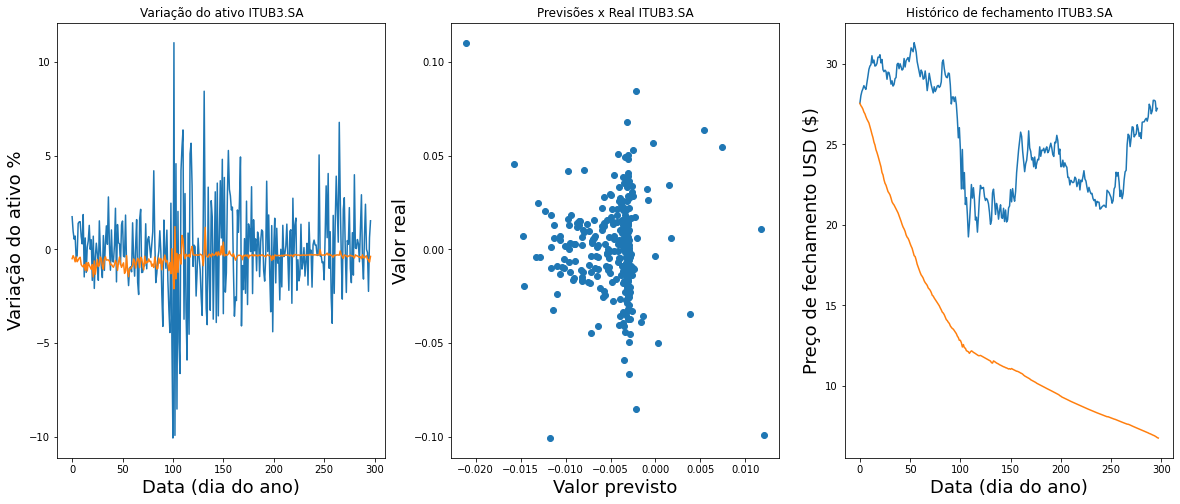

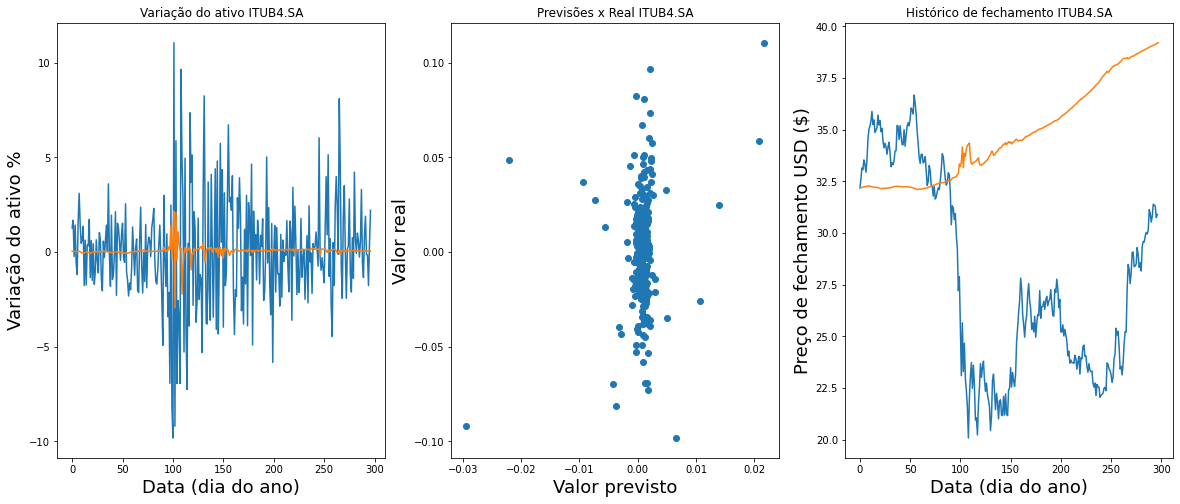

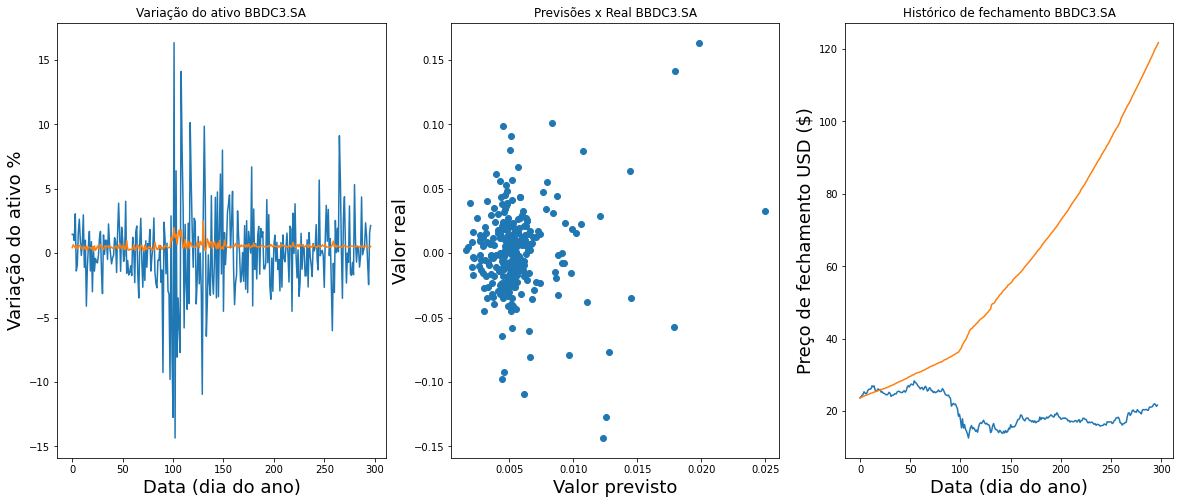

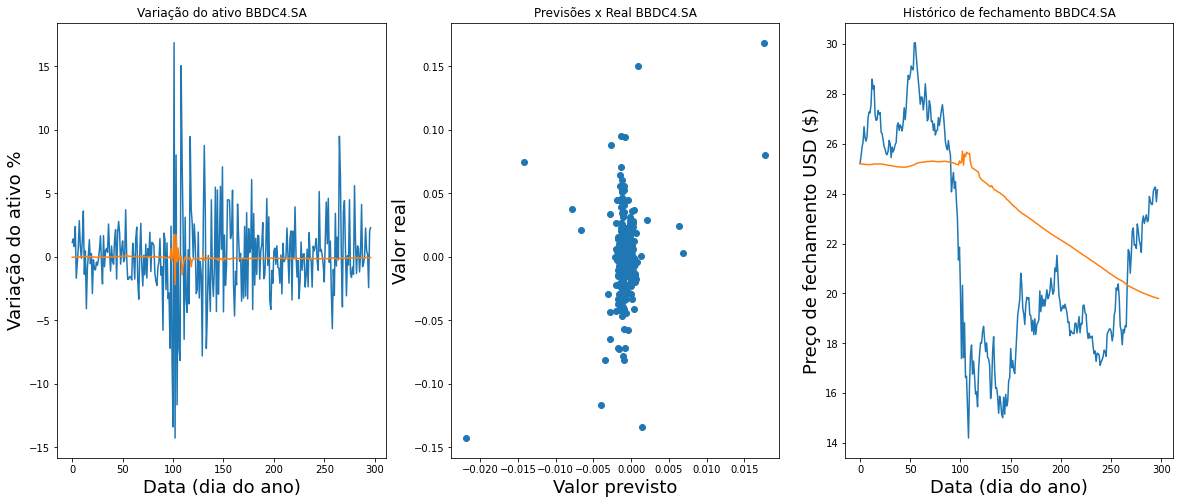

In [52]:
# predições

for i in range(len(models)):
  predictions = np.squeeze(models[i].predict(np.expand_dims(assetVariables[i]['x_test'], axis=1)))
  plotVariationAndPriceOf(predictions, assetVariables[i]['y_test'], assetVariables[i]['asset_test']['Close'], assetsNames[i])

# resultados
# results = model.evaluate(assetsFiltered[0]['x_test'],assetsFiltered[0]['y_test'])
# results

In [53]:
# test = assetVariableUnion['x_train']

# len(test.columns)

In [54]:
nameSufix = 'all' + str(createType)
trainAndReturnModelWith(assetVariableUnion['x_train'], assetVariableUnion['y_train'], modelsPath + baseModelName + nameSufix)
# print(assetVariableUnion['x_train'], assetVariableUnion['y_train'])

allmodel = load_model(modelsPath + baseModelName + nameSufix + '.hdf5')

input shape (1, 9)
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 64)                18944     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 19,009
Trainable params: 19,009
Non-trainable params: 0
_________________________________________________________________
174/174 [==============================] - 3s 4ms/step - loss: 0.0137
Saved model at best_models/dietsche_all1.hdf5
Epoch 1/50
174/174 [==============================] - 1s 4ms/step - loss: 0.0136
Epoch 2/50
174/174 [==============================] - 1s 3ms/step - loss: 0.0135
Epoch 3/50
174/174 [==============================] - 1s 4ms/step - loss: 0.0138
Epoch 4/50
174/174 [==============================] - 1s 4ms/step - loss: 0.0136
Epoch 5/50
174/174 [==============================] -

/home/lucas/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


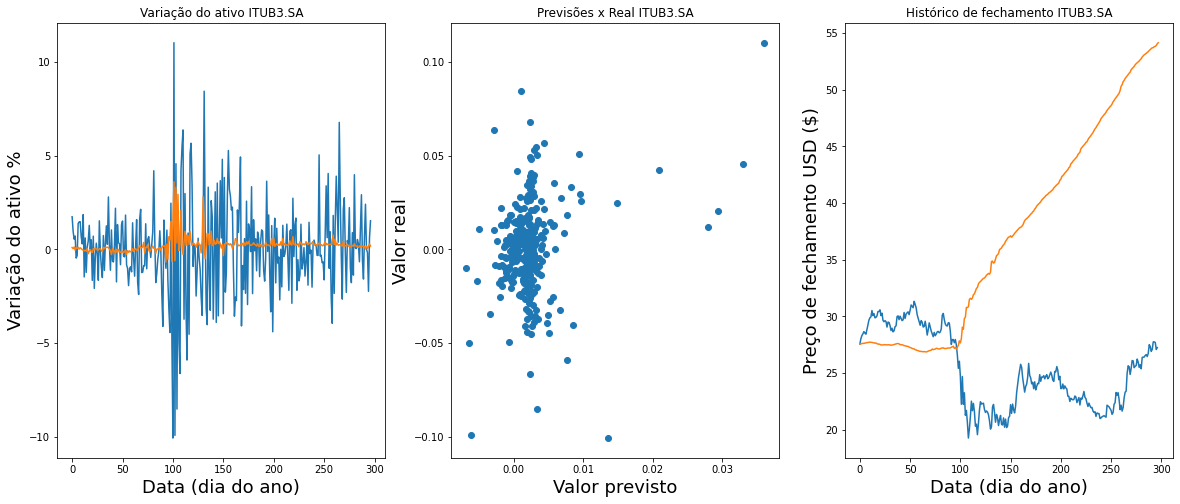

/home/lucas/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


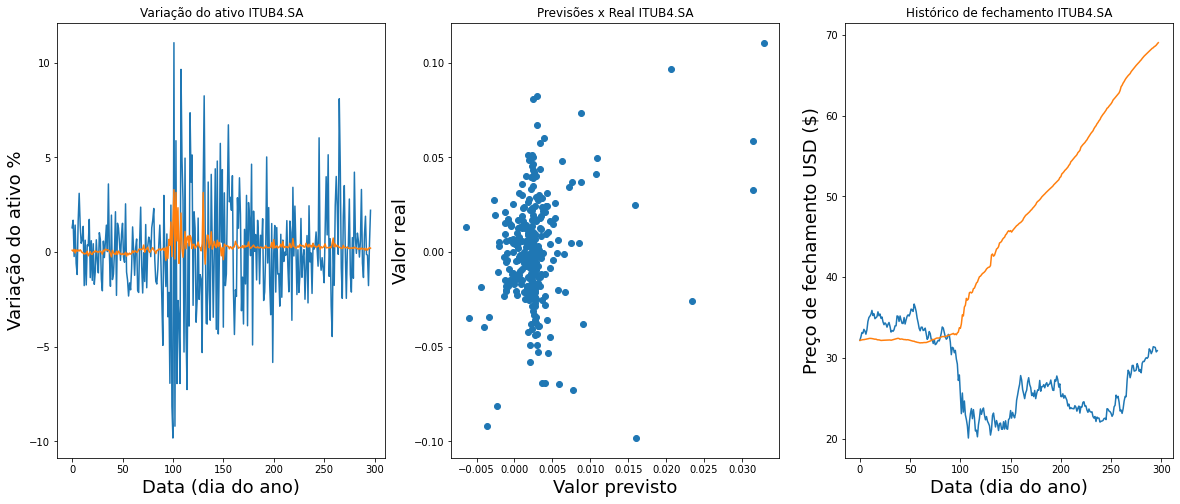

/home/lucas/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


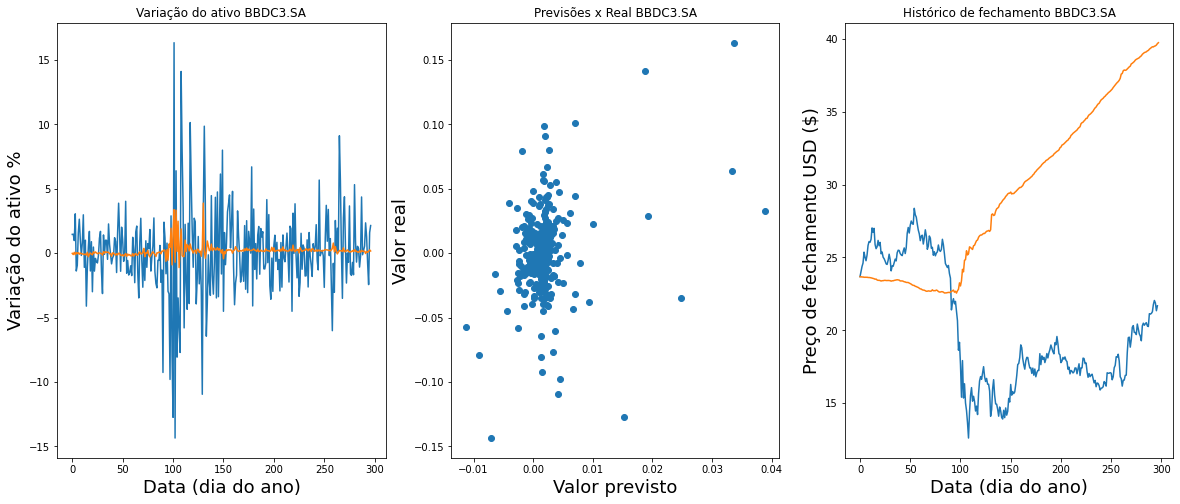

/home/lucas/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


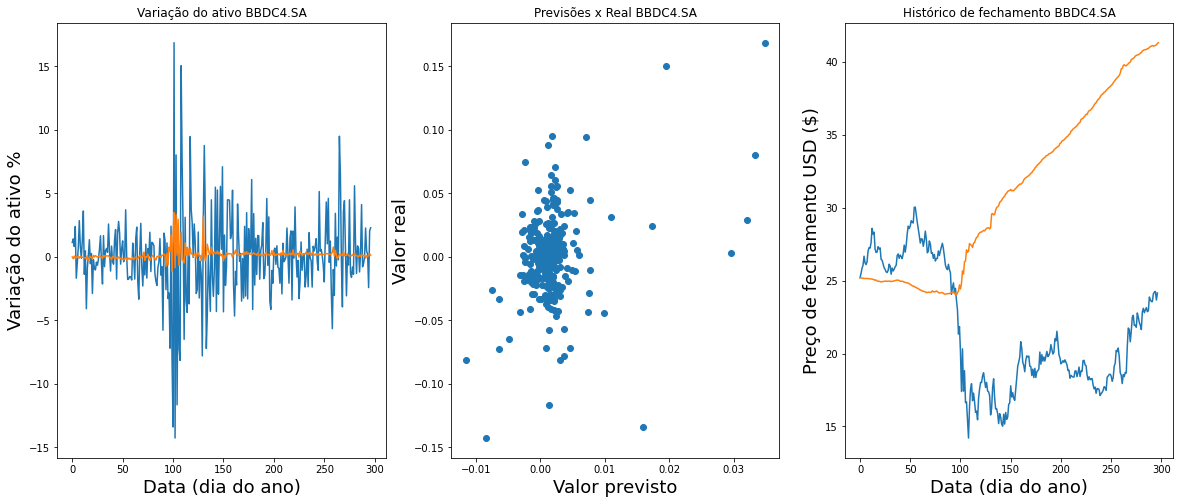

In [55]:
for i in range(len(assetVariables)):
  # predictions = np.squeeze(allmodel.predict(np.expand_dims(assetVariables[i]['x_test'], axis=1)))
  predictions = allmodel.predict(np.expand_dims(assetVariables[i]['x_test'], axis=1))
  plotVariationAndPriceOf(predictions, assetVariables[i]['y_test'], assetVariables[i]['asset_test']['Close'], assetsNames[i])

  # predictions = denormalizeDataFrame(predictions, assetVariables[i]['asset_test']['Var'])
  # variationsProof = denormalizeDataFrame(assetVariables[i]['y_test'], assetVariables[i]['asset_test']['Var'])
  # plotVariationAndPriceOf(predictions, variationsProof, assetVariables[i]['asset_test']['Close'], assetsNames[i])

In [56]:
# from sklearn.model_selection import cross_val_score
# print(
#     cross_val_score(
#         allmodel,
#         pd.concat([assetVariableUnion['x_train'], assetVariableUnion['x_test']], ignore_index=True),
#         pd.concat([assetVariableUnion['y_train'], assetVariableUnion['y_test']], ignore_index=True),
#         cv=3,
#         scoring='accuracy')
#     )